### Compare high-integration, low-integration authors
Let's now look at high-integration and low-integration authors with respect to native verbs, to determine if there are latent factors that differentiate them.

In [1]:
import pandas as pd
native_verb_post_author_data = pd.read_csv('../../data/mined_tweets/native_verbs_post_social_data.tsv', sep='\t')
display(native_verb_post_author_data.head())

,screen_name,id,date,text,native_word_category,native_word_type,has_light_verb,description_location_region,es,total_video_count,...,log_latin_american_media_pct,log_media_URL_pct,log_integrated_verb_pct,log_post_pct,log_URL_share_pct,log_RT_pct,log_balanced_latin_american_media_pct,es_bin,latin_american_media_pct_bin,balanced_latin_american_media_pct_bin
0,000822e5bc974e0,914139329345343488,NaN,Por eso en Guatemala se hace imperativo la int...,native_integrated_verb,terminar,0,latin_america,0.952482,NaN,...,NaN,NaN,-0.094311,0.817638,-3.956807,-2.605467,NaN,es_mid,NaN,NaN
1,000822e5bc974e0,1056780245154648067,2018-10-29 01:30:19,Es que manda a decir un diputado que solo alca...,native_integrated_verb,comprar,0,latin_america,0.952482,NaN,...,NaN,NaN,-0.094311,0.817638,-3.956807,-2.605467,NaN,es_mid,NaN,NaN
2,000822e5bc974e0,1056620451475218432,2018-10-28 14:55:21,# DepresiónCacifNoMeQuiere Consejos. Que me re...,native_integrated_verb,recomendar,0,latin_america,0.952482,NaN,...,NaN,NaN,-0.094311,0.817638,-3.956807,-2.605467,NaN,es_mid,NaN,NaN
3,000822e5bc974e0,1056398890696609792,2018-10-28 00:14:57,Me preocupa que usted no sepa lo que preocupa ...,native_integrated_verb,preguntar,0,latin_america,0.952482,NaN,...,NaN,NaN,-0.094311,0.817638,-3.956807,-2.605467,NaN,es_mid,NaN,NaN
4,000822e5bc974e0,1056373148453613568,2018-10-27 22:32:39,# Olancho # Honduras nueva # CaravanaDeMigrant...,native_integrated_verb,preguntar,0,latin_america,0.952482,NaN,...,NaN,NaN,-0.094311,0.817638,-3.956807,-2.605467,NaN,es_mid,NaN,NaN


Load prior data

In [ ]:
from data_helpers import load_data_from_dirs
data_dir = '../../data/mined_tweets/loanword_author_tweets_all_archives/'
use_cols = ['screen_name', 'lang', 'lang_score', 'text', 'urls']
author_post_data = load_data_from_dirs([data_dir], use_cols=use_cols)
author_post_data.fillna('', inplace=True)
# clean text for matching
author_post_data = author_post_data.assign(**{
    'clean_text' : author_post_data.loc[:, 'text'].apply(lambda x: x.lower())
})

Compute rate of integration per author.

In [ ]:
# identify high-integration authors
# per-author integration rate
def compute_integration_rate(data):
    word_var = 'native_word_type'
    integrated_rate = data.groupby(word_var).apply(lambda x: 1-(x.loc[:, 'has_light_verb'].sum() / x.shape[0])).mean()
    return integrated_rate
author_var = 'screen_name'
per_author_integration = native_verb_post_author_data.groupby(author_var).apply(compute_integration_rate)
per_author_integration.sort_values(inplace=True, ascending=False)
display(per_author_integration.head())

In [ ]:
# filter by count
author_counts = native_verb_post_author_data.loc[:, author_var].value_counts()
min_count = 5
freq_authors = author_counts[author_counts >= min_count].index.tolist()
freq_author_integration = per_author_integration[per_author_integration.index.isin(freq_authors)]
display(freq_author_integration.head(10))
display(freq_author_integration.tail(10))

In [ ]:
# plot distribution of integration rates
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.kdeplot(freq_author_integration)
plt.xlabel('integration rate')
plt.show()

OK! Most people tend to use integrated verbs most of the time.

Let's split into "high" and "normal".

In [ ]:
high_integration_cutoff = 1.
high_integration_authors = freq_author_integration[freq_author_integration >= high_integration_cutoff].index.tolist()
low_integration_authors = freq_author_integration[freq_author_integration < high_integration_cutoff].index.tolist()
print('%d high integration authors'%(len(high_integration_authors)))
print('%d low integration authors'%(len(low_integration_authors)))

In [ ]:
# store as author-type data for later
author_integration_type_data = pd.concat([pd.DataFrame(high_integration_authors, columns=['screen_name']).assign(**{'author_type':'high_integration'}), 
                                          pd.DataFrame(low_integration_authors, columns=['screen_name']).assign(**{'author_type':'low_integration'})])
print(author_integration_type_data)

### Compare style in high-integration vs. low-integration authors
Are there consistent stylistic differences in the authors?

To avoid confounds, we will remove all mentions of loanwords and native verbs, then restrict to Spanish-language posts.

In [ ]:
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import conjugate_verb, conjugate_light_verb, remove_ambiguous_verb_forms
import re
# get loanword query data
loanword_integrated_verb_query_data = pd.read_csv('../../data/loanword_resources/wiktionary_twitter_reddit_loanword_verbs_integrated_verbs_query_phrases.tsv', sep='\t').rename(columns={'verb' : 'integrated_verb_query'})
loanword_light_verb_query_data = pd.read_csv('../../data/loanword_resources/wiktionary_twitter_reddit_loanword_verbs_light_verbs_query_phrases.tsv', sep='\t').rename(columns={'verb' : 'light_verb_query'})
loanword_query_data = pd.merge(loanword_integrated_verb_query_data, loanword_light_verb_query_data, on='loanword')
# get native verb query data
native_verb_query_data = pd.read_csv('../../data/loanword_resources/native_verb_light_verb_pairs.csv', sep=',')
# generate queries
native_verb_query_data = native_verb_query_data.assign(**{
    'integrated_verb_query' : native_verb_query_data.loc[:, 'integrated_verb'].apply(lambda x: re.compile('|'.join(remove_ambiguous_verb_forms(conjugate_verb(x))))),
    'light_verb_query' : native_verb_query_data.loc[:, 'light_verb'].apply(lambda x: re.compile('|'.join(list(map(lambda y: f'({y})', conjugate_light_verb(x)))))),
})
# get matchers
loanword_matchers = (
    loanword_query_data.loc[:, 'integrated_verb_query'].apply(lambda x: re.compile(x)).values.tolist() + 
    loanword_query_data.loc[:, 'light_verb_query'].apply(lambda x: re.compile(x)).values.tolist()
                    )
native_verb_matchers = (
    native_verb_query_data.loc[:, 'integrated_verb_query'].apply(lambda x: re.compile(x)).values.tolist() + 
    native_verb_query_data.loc[:, 'light_verb_query'].apply(lambda x: re.compile(x)).values.tolist()
)
print(len(loanword_matchers))
print(len(native_verb_matchers))

In [ ]:
def match_any(text, matchers):
    for matcher in matchers:
        if(matcher.search(text) is not None):
            return True
    return False

In [ ]:
from pandarallel import pandarallel
## WARNING this may blow up memory because it copies (??) all the data between processes
JOBS = 10
pandarallel.initialize(nb_workers=JOBS)
author_post_data = author_post_data.assign(**{
    'contains_loanword' : author_post_data.loc[:, 'clean_text'].parallel_apply(lambda x: match_any(x, loanword_matchers))
})

In [ ]:
author_post_data = author_post_data.assign(**{
    'contains_native_verb' : author_post_data.loc[:, 'clean_text'].parallel_apply(lambda x: match_any(x, native_verb_matchers))
})

In [ ]:
print(author_post_data.loc[:, 'contains_loanword'].sum())
print(author_post_data.loc[:, 'contains_native_verb'].sum())
print(author_post_data.shape[0])

Let's get the style features for all authors.

In [ ]:
# restrict to original data
# filter out RT posts
import re
RT_matcher = re.compile('^RT @\w+')
txt_var = 'text'
author_post_data = author_post_data.assign(**{
    'is_shared' : author_post_data.loc[:, txt_var].apply(lambda x: RT_matcher.search(x) is not None)
})
# filter out media posts
matcher = re.compile('(?<=youtube\.com/watch\?v=)[a-zA-Z0-9_\-]+|(?<=youtu\.be/)[a-zA-Z0-9_\-]+|(?<=spotify\.com/track/)[a-zA-Z0-9]+')
author_post_data = author_post_data.assign(**{
    'has_media' : author_post_data.loc[:, txt_var].apply(lambda x: matcher.search(x) is not None)
})
original_author_post_data = author_post_data[~(author_post_data.loc[:, 'is_shared'] | author_post_data.loc[:, 'has_media'])]
# restrict to actual Spanish data
lang = 'es'
# es_original_author_post_data = original_author_post_data[original_author_post_data.loc[:, 'lang_score']!='']
es_original_author_post_data = original_author_post_data[(original_author_post_data.loc[:, 'lang']==lang)]

In [ ]:
# clean text
from data_helpers import clean_tweet_txt
es_original_author_post_data = es_original_author_post_data.assign(**{
    'clean_text' : es_original_author_post_data.loc[:, txt_var].apply(clean_tweet_txt)
})

In [15]:
# combine with author data
author_var = 'screen_name'
integration_author_post_data = pd.merge(es_original_author_post_data, author_integration_type_data, on=author_var)
print(integration_author_post_data.shape[0])

495919


In [17]:
# save for later??
# regex operations are expensive
integration_author_post_data.to_csv('../../data/mined_tweets/native_verb_high_low_integration_author_data.tsv', sep='\t', index=False)

### Compare word use in high-integration authors vs. low-integration authors

In [38]:
import pandas as pd
integration_author_post_data = pd.read_csv('../../data/mined_tweets/native_verb_high_low_integration_author_data.tsv', sep='\t')
es_original_author_post_data = integration_author_post_data[~(integration_author_post_data.loc[:, 'is_shared'] | integration_author_post_data.loc[:, 'has_media']) & (integration_author_post_data.loc[:, 'lang']=='es')]
author_integration_type_data = integration_author_post_data.loc[:, ['screen_name', 'author_type']]

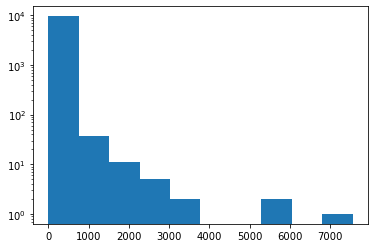

In [19]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
author_counts = es_original_author_post_data.loc[:, 'screen_name'].value_counts()
plt.hist(author_counts)
plt.yscale('log')
plt.show()

In [27]:
# remove frequent posters
import numpy as np
cutoff_pct = 99
cutoff_freq = np.percentile(author_counts, cutoff_pct)
freq_authors = author_counts[author_counts >= cutoff_freq]
print('%d/%d freq authors >= %d'%(len(freq_authors), len(author_counts), cutoff_freq))
es_original_author_post_data = es_original_author_post_data[~es_original_author_post_data.loc[:, 'screen_name'].isin(freq_authors)]

97/9673 freq authors >= 528


In [24]:
# compare all word distributions
from sklearn.feature_extraction.text import CountVectorizer
from stop_words import get_stop_words
from data_helpers import BasicTokenizer
lang_long = 'spanish'
tokenizer = BasicTokenizer(lang=lang_long)
lang = 'es'
lang_stop_words = get_stop_words(lang)
cv = CountVectorizer(min_df=0.0001, max_df=0.75, stop_words=lang_stop_words, tokenizer=tokenizer.tokenize)
dtm = cv.fit_transform(es_original_author_post_data.loc[:, 'clean_text'])
# get vocab lookup
idx_vocab_lookup = {v : k for k,v in cv.vocabulary_.items()}
ordered_vocab = list(zip(*sorted(cv.vocabulary_.items(), key=lambda x: x[1])))[0]
print(dtm.shape)
print(len(ordered_vocab))

(495919, 9259)
9259


In [25]:
# separate by author type
high_integration_dtm = dtm[integration_author_post_data[integration_author_post_data.loc[:, 'author_type']=='high_integration'].index, :]
low_integration_dtm = dtm[integration_author_post_data[integration_author_post_data.loc[:, 'author_type']=='low_integration'].index, :]
# get total counts
import numpy as np
def get_total_word_counts(dtm, ordered_vocab):
    word_counts = pd.Series(np.array(dtm.sum(axis=0))[0], index=ordered_vocab)
    # normalize by proportion
    word_counts = word_counts / word_counts.sum()
    return word_counts
high_integration_author_word_counts = get_total_word_counts(high_integration_dtm, ordered_vocab)
low_integration_author_word_counts = get_total_word_counts(low_integration_dtm, ordered_vocab)
# compute ratio
high_low_integration_author_word_ratio = high_integration_author_word_counts / low_integration_author_word_counts
high_low_integration_author_word_ratio.dropna(inplace=True)
high_low_integration_author_word_ratio = high_low_integration_author_word_ratio[~np.isinf(high_low_integration_author_word_ratio)]

In [29]:
top_k = 50
# high-integration authors
print('high-integration authors')
high_low_integration_author_word_ratio.sort_values(inplace=True, ascending=False)
display(high_low_integration_author_word_ratio.head(top_k))
# low-integration authors
print('low-integration authors')
low_high_integration_author_word_ratio = 1/high_low_integration_author_word_ratio
low_high_integration_author_word_ratio = low_high_integration_author_word_ratio[~np.isinf(low_high_integration_author_word_ratio)]
low_high_integration_author_word_ratio.sort_values(inplace=True, ascending=False)
display(low_high_integration_author_word_ratio.head(top_k))

high-integration authors


unoticias         360.265143
fluida            310.848243
+info             237.519939
aristemo          164.191636
nbalatam           48.619853
interpretado       39.055292
ppopular           34.007329
reducida           29.832322
telesurtv          28.494422
✧                  26.302544
moca               25.505497
aguascalientes     23.911403
ángulo             20.103291
laliga             13.815477
❤️❤️❤️             11.258286
daiana             11.158655
póliza              9.854397
❤❤❤                 9.777107
inning              8.820651
tato                8.590393
caricias            8.448696
gabi                7.847845
📣                   6.376374
u_u                 5.796704
niall               5.705177
veni                5.395394
almería             5.344902
xfa                 5.207372
einstein            5.161827
sentidos            5.157361
wpp                 5.123872
julian              5.085918
anal                5.081173
tyler               5.010008
\             

low-integration authors


http              271.627722
vtvcanal          107.898310
https              67.819803
efe                63.358891
by…                46.421366
revisarlo          43.912103
+detalles          37.638945
dcabellor          33.875051
mashirafael        32.620419
facilítanos        32.620419
🔴|                 29.483840
🌵                  29.065630
►                  28.357695
slds               25.140885
cámbiate           25.092630
+foto              19.715638
villegaspoljak     19.133131
virgin             18.401262
tv…                15.625865
murillo            15.473789
descuida           15.055578
iguana             14.502064
🇨🇺                 12.755420
¿nos               12.642825
……                 12.023552
+video             11.366961
¿deseas            11.291684
presentas          10.664368
revisamos          10.162515
👉…                 10.162515
infobae             9.506246
bsf                 9.252907
molestias           9.174493
¡hola               9.174493
contactarnos  

### Compare high-integration vs. low-integration loanword authors by style

Let's try to formalize these findings with some concrete style metrics:

- word length
- sentence length
- type/token ratio
- standard word use
- POS tag distribution

In [69]:
# compute text metrics
import numpy as np
from functools import reduce
def compute_word_length(text_tokens):
    # TODO: log-transform because of skew??
    token_len = np.array(list(map(len, text_tokens)))
    mean_token_len = np.mean(token_len)
    return mean_token_len
def compute_sentence_length(text_sent_tokens):
    # tokenize sentences
    sent_len = list(map(len, text_sent_tokens))
    mean_sent_len = np.mean(sent_len)
    return mean_sent_len
def compute_type_token_ratio(text_tokens):
    type_token_ratio = len(text_tokens) / len(set(text_tokens))
    return type_token_ratio
def compute_tag_distribution(tagged_sents):
    words, tags = list(zip(*(map(lambda x: list(zip(*x)), tagged_sents))))
    combined_tags = list(reduce(lambda x,y: x+y, tags))
    tag_counts = pd.Series(combined_tags).value_counts()
    tag_dist = tag_counts / tag_counts.sum()
    return tag_dist
def compute_post_length(posts):
    post_len = list(map(len, posts))
    mean_post_len = np.mean(post_len)
    return mean_post_len
def compute_dict_word_pct(text_tokens, dict_words):
    text_dict_words = list(filter(lambda x: x in dict_words, text_tokens))
    dict_word_pct = len(text_dict_words) / len(text_tokens)
    return dict_word_pct
def compute_dict_word_len(text_tokens, dict_words):
    text_dict_words = list(filter(lambda x: x in dict_words, text_tokens))
    dict_word_len = list(map(len, text_dict_words))
    mean_dict_word_len = np.mean(dict_word_len)
    return mean_dict_word_len
# TODO: word entropy??

In [48]:
# tokenize text => words, sentences
def word_tokenize_clean(text, tokenizer, filter_word_matcher):
    text_clean = filter_word_matcher.sub('', text)
    text_tokens = tokenizer.tokenize(text_clean)
    return text_tokens
def sent_tokenize_clean(text, word_tokenizer, sent_tokenizer, filter_word_matcher):
    text_clean = filter_word_matcher.sub('', text)
    text_sents = list(filter(lambda x: len(x) > 0, sent_tokenizer.tokenize(text_clean)))
    sent_tokens = list(map(lambda x: word_tokenizer.tokenize(x), text_sents))
    return sent_tokens
from data_helpers import BasicTokenizer
from nltk.tokenize import PunktSentenceTokenizer
import re
word_tokenizer = BasicTokenizer(lang='spanish')
sent_tokenizer = PunktSentenceTokenizer()
text_var = 'clean_text'
filter_words = set(['@USER', '#HASH', '<NUM>', '<URL>'])
filter_word_matcher = re.compile('|'.join(filter_words))
integration_author_post_data = integration_author_post_data.assign(**{
    'text_tokens' : integration_author_post_data.loc[:, 'clean_text'].apply(lambda x: word_tokenize_clean(x, word_tokenizer, filter_word_matcher))
})
integration_author_post_data = integration_author_post_data.assign(**{
    'text_sents' : integration_author_post_data.loc[:, 'clean_text'].apply(lambda x: sent_tokenize_clean(x, word_tokenizer, sent_tokenizer, filter_word_matcher))
})
# get tokens per author
from functools import reduce
author_var = 'screen_name'
integration_author_tokens = integration_author_post_data.groupby(author_var).apply(lambda x: list(reduce(lambda y,z: y+z, x.loc[:, 'text_tokens'].values.tolist())))
# get sentences per author: list of token lists
integration_author_sents = integration_author_post_data.groupby(author_var).apply(lambda x: list(reduce(lambda y,z: y+z, x.loc[:, 'text_sents'].values.tolist())))
# get posts per author: list of post text
integration_author_post_text = integration_author_post_data.groupby(author_var).apply(lambda x: x.loc[:, 'clean_text'].values.tolist())

In [59]:
# get Spanish dict words
ES_dict_words = set(map(lambda x: x.strip(), open('../../data/loanword_resources/ES_words.txt', encoding='ISO-8859-1')))
print(len(ES_dict_words))

175082


In [70]:
# compute style per author
author_var = 'screen_name'
# remove any authors without tokens => filtering for @USER etc.
integration_author_tokens = integration_author_tokens[integration_author_tokens.apply(len) > 0]
integration_author_sents = integration_author_sents[integration_author_sents.apply(lambda x: len(list(filter(lambda y: len(y) > 0, x)))) > 0]
integration_author_word_length = integration_author_tokens.apply(lambda x: compute_word_length(x))
integration_author_type_token_ratio = integration_author_tokens.apply(lambda x: compute_type_token_ratio(x))
integration_author_sent_length = integration_author_sents.apply(lambda x: compute_sentence_length(x))
integration_author_post_length = integration_author_post_text.apply(lambda x: compute_post_length(x))
integration_author_dict_word_pct = integration_author_tokens.apply(lambda x: compute_dict_word_pct(x, ES_dict_words))
integration_author_dict_word_len = integration_author_tokens.apply(lambda x: compute_dict_word_len(x, ES_dict_words))

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [71]:
author_style_data = pd.concat([integration_author_word_length, integration_author_type_token_ratio, 
                               integration_author_sent_length, integration_author_post_length,
                               integration_author_dict_word_pct, integration_author_dict_word_len], axis=1).reset_index()
author_style_data = author_style_data.rename(columns={'index':'screen_name', 
                                                      0:'word_len', 1:'type_token_ratio', 
                                                      2:'sent_len', 3:'post_len', 
                                                      4:'dict_word_pct', 5:'dict_word_len'})
author_style_data = pd.merge(author_style_data, author_integration_type_data, on='screen_name')

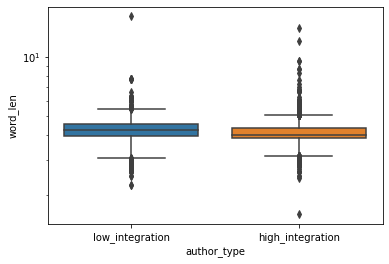

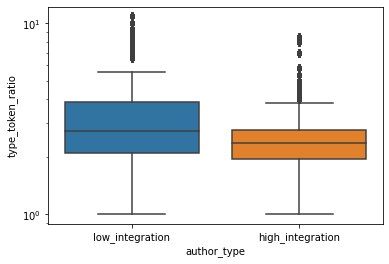

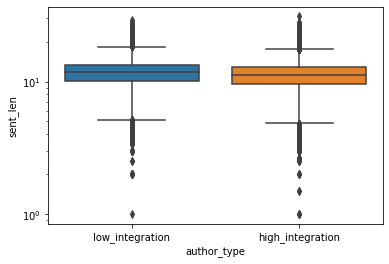

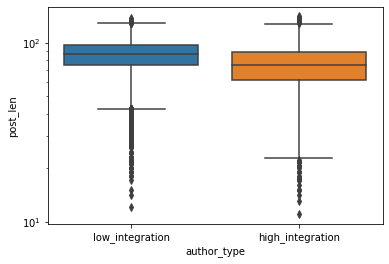

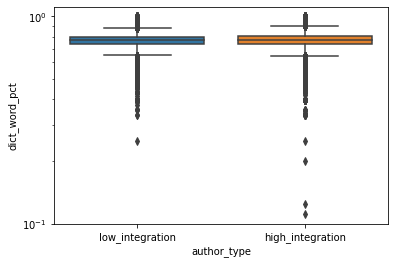

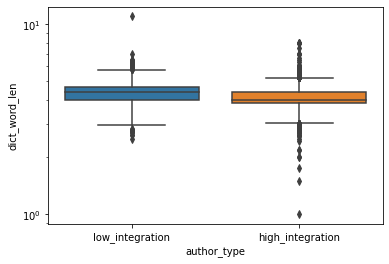

style var word_len has diff -0.141 with test stat 22943062767.000 (p=0.000E+00)
style var type_token_ratio has diff -0.861 with test stat 21937318901.000 (p=0.000E+00)
style var sent_len has diff -0.595 with test stat 25610235812.500 (p=0.000E+00)
style var post_len has diff -9.572 with test stat 20595254375.500 (p=0.000E+00)
style var dict_word_pct has diff 0.006 with test stat 27908731134.000 (p=0.000E+00)
style var dict_word_len has diff -0.216 with test stat 20451809379.000 (p=0.000E+00)


In [72]:
# plot distributions
import seaborn as sns
style_vars = ['word_len', 'type_token_ratio', 'sent_len', 'post_len', 'dict_word_pct', 'dict_word_len']
for style_var in style_vars:
    sns.boxplot(x='author_type', y=style_var, data=author_style_data)
    plt.yscale('log')
    plt.show()
# compare distributions
from scipy.stats import mannwhitneyu
for style_var in style_vars:
    data_1 = author_style_data[author_style_data.loc[:, 'author_type']=='high_integration'].loc[:, style_var]
    data_2 = author_style_data[author_style_data.loc[:, 'author_type']=='low_integration'].loc[:, style_var]
    mean_diff = data_1.mean() - data_2.mean()
    test_stat, p_val = mannwhitneyu(data_1, data_2)
    print('style var %s has diff %.3f with test stat %.3f (p=%.3E)'%(style_var, mean_diff, test_stat, p_val))

OK! High-integration authors have:

- lower word length (all words and dictionary words)
- lower type/token ratio (because conformity? less creativity)
- lower sentence length (because more concise, actual punctuation breaks?)
- shorter posts (less lengthening, repetition?)

The sentences finding is weird, so let's look at some examples of sentences from high-integration authors and low-integration author.

In [46]:
import numpy as np
np.random.seed(123)
sample_size = 100
author_var = 'screen_name'
author_type_var = 'author_type'
high_integration_sample_authors = np.random.choice(integration_author_post_data[integration_author_post_data.loc[:, author_type_var]=='high_integration'].loc[:, author_var].values, sample_size, replace=False)
low_integration_sample_authors = np.random.choice(integration_author_post_data[integration_author_post_data.loc[:, author_type_var]=='low_integration'].loc[:, author_var].values, sample_size, replace=False)
high_integration_sample_sents = integration_author_post_data[integration_author_post_data.loc[:, author_var].isin(high_integration_sample_authors)].loc[:, 'text_sents'].apply(lambda x: ' '.join(map(lambda y: ' '.join(y), x)))
low_integration_sample_sents = integration_author_post_data[integration_author_post_data.loc[:, author_var].isin(low_integration_sample_authors)].loc[:, 'text_sents'].apply(lambda x: ' '.join(map(lambda y: ' '.join(y), x)))
print('high-integration author sentences')
print(high_integration_sample_sents.values[:20])
print('low-integration author sentences')
print(low_integration_sample_sents.values[:20])

high-integration author sentences
['el presidente lenín moreno dispone la revisión de la ley de plusvalía .'
 "' cuatro minutos de reposición -"
 'noticias : maduro vuelve a cambiar al titular del ministerio de exteriores venezolano .'
 "no te pierdas : tu programa `` hablemos del guayas '' escúchalo por la radio del ecuador ."
 'deportes : hoy : de paraguay ante es la cita copera en asunción .'
 'neymar no pudo contener las lágrimas en el minuto de silencio por las víctimas del atentando en barcelona previo al…'
 'todos los programas de los puedes ver en vivo por nuestra página de facebook . ( radio atalaya …'
 'noticias : aumentó a la cifra de muertos en protestas en las últimas horas…'
 '- arias `` san lorenzo nos esperó en su propio campo , el equipo lo superó en el juego , …'
 'reabren en guayaquil plantel provincia del azuay e instan a proteger más a chicos.…'
 'alineación confirmada de para enfrentar al en la'
 'al aire con tu programa informativo ecuador en movimiento junto a p

OK! This gives a different perspective.

Low-integration authors:
- use more run-on sentences (longer sentences)
- use more respellings (higher type-token ratio)
- use more expressive lengthening (longer words)

Let's check out the POS tags too.

Weird! So in original content, the low-integration authors tend to discuss more formal topics than the high-integration authors, leading to a notable difference in sentence size.

In [63]:
# get POS tags
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import tag_sents
lang = 'spanish'
integration_author_sents = integration_author_post_data.loc[:, 'clean_text'].values
# WARNING parallel tagging blows up memory
tag_type = 'parallel'
# takes ~5 mins for 50K sentences
# takes several hours for 500K sentences?? ugh!
integration_author_tagged_sents = tag_sents(integration_author_sents, lang=lang, port=9003, tag_type=tag_type)

INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [64]:
len(integration_author_tagged_sents)

495919

In [65]:
# compute distribution
integration_author_post_data = integration_author_post_data.assign(**{
    'tagged_sent' : integration_author_tagged_sents
})
# save for posterity
integration_author_post_data.to_csv('../../data/mined_tweets/native_verb_high_low_integration_author_data.tsv', sep='\t', index=False)

In [66]:
author_var = 'screen_name'
author_type_var = 'author_type'
integration_author_tag_distribution = integration_author_post_data.groupby([author_var, author_type_var]).apply(lambda x: compute_tag_distribution(x.loc[:, 'tagged_sent'].values)).reset_index().rename(columns={'level_2':'tag', 0:'tag_pct'})

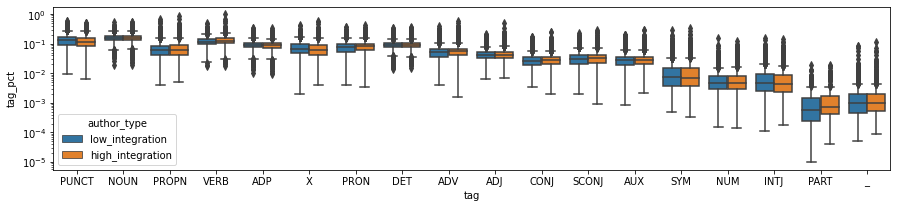

In [67]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,3))
sns.boxplot(x='tag', y='tag_pct', hue='author_type', data=integration_author_tag_distribution)
plt.yscale('log')
plt.show()

These rates look pretty much the same. Let's compare these statistically.

In [68]:
from scipy.stats import mannwhitneyu
p_val_upper = 0.05 / integration_author_tag_distribution.loc[:, 'tag'].nunique()
for tag_i, data_i in integration_author_tag_distribution.groupby('tag'):
    high_integration_author_tag_pct = data_i[data_i.loc[:, 'author_type']=='high_integration'].loc[:, 'tag_pct']
    low_integration_author_tag_pct = data_i[data_i.loc[:, 'author_type']=='low_integration'].loc[:, 'tag_pct']
    mean_diff = high_integration_author_tag_pct.mean() - low_integration_author_tag_pct.mean()
    test_stat, p_val = mannwhitneyu(high_integration_author_tag_pct, low_integration_author_tag_pct)
    if(p_val < p_val_upper):
        print('tag %s has diff %.3f, test stat=%.3f (p=%.3E)'%(tag_i, mean_diff, test_stat, p_val))

tag ADP has diff -0.002, test stat=10511694.000 (p=7.280E-06)
tag ADV has diff 0.005, test stat=9458367.500 (p=5.807E-18)
tag DET has diff -0.001, test stat=10777137.500 (p=2.016E-03)
tag INTJ has diff -0.001, test stat=2348619.500 (p=2.386E-04)
tag PART has diff 0.000, test stat=51903.000 (p=5.553E-04)
tag PRON has diff 0.005, test stat=9781691.000 (p=8.279E-17)
tag PROPN has diff 0.004, test stat=9959615.000 (p=1.124E-04)
tag PUNCT has diff -0.010, test stat=9946563.500 (p=5.710E-23)
tag SCONJ has diff 0.002, test stat=8959431.000 (p=2.738E-06)
tag VERB has diff 0.008, test stat=9899174.000 (p=4.492E-30)
tag X has diff -0.004, test stat=8826860.000 (p=2.619E-13)


OK! We actually do have significant differences in the median values.

High integration authors tend to use more:
- `ADV`
- `PART`
- `PRON`
- `PROPN`
- `VERB`

High integration authors tend to use fewer:
- `ADP`
- `DET`
- `INTJ`
- `PUNCT`
- `X`

### 

Let's re-do the word length comparison but using each POS category instead of all words.

In [136]:
# this is going to be fun
author_var = 'screen_name'
author_type_var = 'author_type'
tag_var = 'tag'
# reorganize tags
integration_author_POS_words = integration_author_post_data.groupby([author_var, author_type_var]).apply(lambda x: pd.concat(x.loc[:, 'tagged_sent'].apply(lambda x: pd.DataFrame(x, columns=['word', 'tag'])).tolist(), axis=0))
# remove bad words
non_words = set(['USER', '@', 'HASH', 'URL',])
integration_author_POS_words = integration_author_POS_words[~integration_author_POS_words.loc[:, 'word'].isin(non_words)]

In [137]:
integration_author_POS_tag_word_len = integration_author_POS_words.groupby(level=0, axis=0).apply(lambda x: x.groupby('tag').apply(lambda y: np.mean(y.loc[:, 'word'].apply(len))))
integration_author_POS_tag_word_len = integration_author_POS_tag_word_len.reset_index().rename(columns={0:'mean_word_len'})
integration_author_POS_tag_word_len = pd.merge(integration_author_POS_tag_word_len, integration_author_post_data.loc[:, ['screen_name', 'author_type']].drop_duplicates('screen_name', inplace=False), on='screen_name')
print(integration_author_POS_tag_word_len)

            screen_name    tag  mean_word_len      author_type
0       000822e5bc974e0    ADJ       8.034483  low_integration
1       000822e5bc974e0    ADP       2.196721  low_integration
2       000822e5bc974e0    ADV       3.531250  low_integration
3       000822e5bc974e0    AUX       3.363636  low_integration
4       000822e5bc974e0   CONJ       1.652174  low_integration
...                 ...    ...            ...              ...
135872          zznenno  PUNCT       1.000000  low_integration
135873          zznenno  SCONJ       3.666667  low_integration
135874          zznenno    SYM       2.000000  low_integration
135875          zznenno   VERB       6.909091  low_integration
135876          zznenno      X       3.000000  low_integration

[135877 rows x 4 columns]


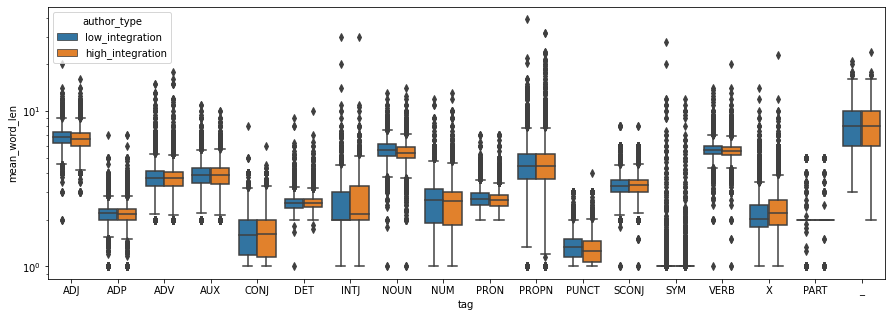

In [138]:
import seaborn as sns
plt.figure(figsize=(15, 5))
sns.boxplot(x='tag', y='mean_word_len', hue='author_type', data=integration_author_POS_tag_word_len)
plt.yscale('log')
plt.show()

In [139]:
# which differences are significant?
from scipy.stats import mannwhitneyu
p_val_upper = 0.05 / integration_author_POS_tag_word_len.loc[:, 'tag'].nunique()
for tag_i, data_i in integration_author_POS_tag_word_len.groupby('tag'):
    low_integration_data_i = data_i[data_i.loc[:, 'author_type']=='low_integration'].loc[:, 'mean_word_len']
    high_integration_data_i = data_i[data_i.loc[:, 'author_type']=='high_integration'].loc[:, 'mean_word_len']
    mean_diff_i = high_integration_data_i.mean() - low_integration_data_i.mean()
    test_stat, p_val = mannwhitneyu(high_integration_data_i, low_integration_data_i)
    if(p_val < p_val_upper):
        print('tag=%s, diff=%.3f (test stat=%.3E, p=%.3E)'%(tag_i, mean_diff_i, test_stat, p_val))

tag=ADJ, diff=-0.165 (test stat=9.190E+06, p=4.414E-17)
tag=INTJ, diff=0.086 (test stat=2.371E+06, p=1.298E-03)
tag=NOUN, diff=-0.216 (test stat=9.624E+06, p=4.097E-43)
tag=PRON, diff=-0.054 (test stat=9.817E+06, p=7.673E-16)
tag=PUNCT, diff=-0.055 (test stat=9.392E+06, p=6.182E-26)
tag=VERB, diff=-0.073 (test stat=1.048E+07, p=1.215E-12)
tag=X, diff=0.157 (test stat=8.370E+06, p=8.617E-22)


High integration authors use:
- shorter adjectives, nouns, pronouns, verbs
- longer interjections, non-words (code-switches?)

This is the opposite of what we expected, based on the previous analysis.

What are some of the long words associated with each author type/tag category?

In [130]:
import numpy as np
np.random.seed(123)
# integration_author_POS_words = integration_author_POS_words.assign(**{
#     'len' : integration_author_POS_words.loc[:, 'word'].apply(lambda x: len(x))
# })
sample_size = 5
for tag_i, data_i in integration_author_POS_words.groupby('tag'):
    data_i = data_i.reset_index()
    for author_type_j, data_j in data_i.groupby('author_type'):
        print(f'tag={tag_i} author type={author_type_j}')
        author_sample_j = np.random.choice(data_j.loc[:, 'screen_name'].unique(), sample_size, replace=False)
        data_j = data_j[data_j.loc[:, 'screen_name'].isin(author_sample_j)]
        for author_k, data_k in data_j.groupby('screen_name'):
            data_k.sort_values('len', inplace=True, ascending=False)
            print(data_k.loc[:, ['word', 'len']].head(5))
            print(data_k.loc[:, ['word', 'len']].tail(5))

tag=ADJ author type=high_integration
                 word  len
16063  jajajajajajaja   14
16101    insoportable   12
16046      complicado   10
16072        tremendo    8
16057        amarillo    8
       word  len
16048  loca    4
16097  loco    4
16061  míos    4
16084  akme    4
16078   tas    3
          word  len
70989  barroso    7
          word  len
70989  barroso    7
           word  len
154549  puestos    7
           word  len
154549  puestos    7
                word  len
187405  inteligentes   12
187399   carabineros   11
187402     apitutado    9
187401       nefasto    7
187404       chileno    7
           word  len
187404  chileno    7
187398   andres    6
187397    mejor    5
187400    bueno    5
187403    claro    5
               word  len
377784  sociológica   11
377790   importante   10
377789   carterista   10
377788   avaricioso   10
377780    estresado    9
         word  len
377783  medio    5
377779  godín    5
377778   buen    4
377786   buen    4
377772  

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/minicond

tag=ADP author type=high_integration
          word  len
11157  gracias    7
11174      con    3
11172      por    3
11170      sin    3
11152      con    3
      word  len
11171    a    1
11163    a    1
11173    a    1
11162    a    1
11175    a    1
       word  len
296026   de    2
       word  len
296026   de    2
         word  len
314587  hasta    5
314582   como    4
314585   para    4
314590   para    4
314584    sin    3
       word  len
314584  sin    3
314586   de    2
314588   de    2
314589   de    2
314583    a    1
       word  len
556778  por    3
556776  por    3
556762  por    3
556773  por    3
556757  sin    3
       word  len
556770    a    1
556775    a    1
556760    a    1
556777    a    1
556779    a    1
           word  len
704236  durante    7
704339    hasta    5
704381    sobre    5
704410    hasta    5
704214    hasta    5
       word  len
704397    a    1
704349    a    1
704277    a    1
704257    a    1
704376    a    1
tag=ADP author type=low_integra

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/minicond

tag=ADV author type=high_integration
          word  len
76332  siempre    7
76331    nunca    5
76327      asi    3
76330      mal    3
76335      más    3
      word  len
76326   no    2
76328   no    2
76329   no    2
76333   no    2
76334   no    2
           word  len
125176  después    7
125182  después    7
125177    donde    5
125178     bien    4
125180     bien    4
       word  len
125175  ahí    3
125179  más    3
125181  hoy    3
125183   no    2
125184   no    2
              word  len
133589  totalmente   10
133597     también    7
133580      seguro    6
133581      mañana    6
133591       junto    5
       word  len
133584  aún    3
133590  más    3
133588   no    2
133594   no    2
133586   no    2
              word  len
163898  totalmente   10
163893     siempre    7
163895       donde    5
163896         más    3
163897         así    3
       word  len
163896  más    3
163897  así    3
163892   no    2
163894   no    2
163899   no    2
               word  len
32

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/minicond

tag=AUX author type=high_integration
         word  len
27296  estaba    6
27293  podría    6
27285  empecé    6
27288  empecé    6
27290   comen    5
      word  len
27287   es    2
27284   es    2
27295   es    2
27297   va    2
27298   es    2
              word  len
48586  discutiendo   11
48617   discutimos   10
48587     deberían    8
48607      debería    7
48599      podemos    7
      word  len
48603   es    2
48616   es    2
48602   es    2
48594   es    2
48620   es    2
            word  len
106463  capitulo    8
106479   hubiera    7
106509   empiece    7
106532    mentir    6
106481    podría    6
       word  len
106496   es    2
106497   es    2
106499   es    2
106501   es    2
106492   he    2
         word  len
168187  puedo    5
         word  len
168187  puedo    5
              word  len
176325  concentrar   10
176309     podamos    7
176311      pueden    6
176321      pueden    6
176327       haber    5
       word  len
176310  voy    3
176320   es    2
176312  

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/minicond

tag=CONJ author type=high_integration
      word  len
72739    y    1
      word  len
72739    y    1
       word  len
78538  como    4
78545  pero    4
78550  pero    4
78559  pero    4
78565  pero    4
      word  len
78561    y    1
78560    y    1
78548    y    1
78551    y    1
78577    y    1
      word  len
81511    y    1
      word  len
81511    y    1
         word  len
86129  cuanta    6
86127    pero    4
86123       y    1
86124       y    1
86125       y    1
      word  len
86123    y    1
86124    y    1
86125    y    1
86126    y    1
86128    y    1
       word  len
106362   ni    2
106361    y    1
106363    y    1
       word  len
106362   ni    2
106361    y    1
106363    y    1
tag=CONJ author type=low_integration
      word  len
5936  pero    4
5930     y    1
5931     y    1
5932     y    1
5933     y    1
     word  len
5933    y    1
5934    y    1
5935    y    1
5937    y    1
5938    y    1
       word  len
44173  pero    4
44169   que    3
44170     y    1

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/minicond

tag=DET author type=high_integration
         word  len
297174  todos    5
297172    mis    3
297176    los    3
297173     el    2
297175     la    2
         word  len
297174  todos    5
297172    mis    3
297176    los    3
297173     el    2
297175     la    2
         word  len
359193  aquel    5
359192     un    2
         word  len
359193  aquel    5
359192     un    2
       word  len
554500  una    3
554503  los    3
554505  los    3
554507  las    3
554513  una    3
       word  len
554509   la    2
554510   el    2
554511   mi    2
554512   su    2
554514   lo    2
        word  len
610121  todo    4
610108   tus    3
610118   una    3
610117   los    3
610101   las    3
       word  len
610115   un    2
610112   la    2
610104   el    2
610103   un    2
610127   mi    2
           word  len
850056  nuestro    7
850054     todo    4
850055       lo    2
850057       el    2
850058       la    2
           word  len
850056  nuestro    7
850054     todo    4
850055       lo   

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/minicond

tag=INTJ author type=high_integration
     word  len
8884  url    3
8886  url    3
8883    <    1
8885    <    1
     word  len
8884  url    3
8886  url    3
8883    <    1
8885    <    1
      word  len
15627    <    1
15628    <    1
15629    <    1
15630    <    1
15631    <    1
      word  len
15629    <    1
15630    <    1
15631    <    1
15632    <    1
15633    <    1
        word  len
16081  ojalá    5
16082     ay    2
        word  len
16081  ojalá    5
16082     ay    2
             word  len
24269  jajajajaja   10
24263       ojalá    5
24270       becks    5
24264        nahh    4
24262         url    3
      word  len
24268  url    3
24271   ay    2
24261    <    1
24265    <    1
24267    <    1
         word  len
30322  hombre    6
30321      ay    2
30323      pd    2
30324      ay    2
         word  len
30322  hombre    6
30321      ay    2
30323      pd    2
30324      ay    2
tag=INTJ author type=low_integration
     word  len
7279   ay    2
7280   ay    2
7281  

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/minicond

tag=NOUN author type=high_integration
                     word  len
223495  diabloooooooooooo   17
223579     presentaciones   14
223549      carajoooooooo   13
223580      ajajajajajaja   13
223453        enchularnos   11
       word  len
223526    c    1
223525    v    1
223518    m    1
223573    >    1
223536    m    1
                    word  len
683117  independentistas   16
682503   adoctrinamiento   15
682540   enchironamiento   15
683100    estupefaciente   14
683011     provocaciones   13
       word  len
683010    >    1
682491    <    1
682485    >    1
682711    >    1
682886    <    1
              word  len
696031  difrutaria   10
696024   corneador    9
696019     mujeres    7
696021      tetona    6
696022      región    6
        word  len
696027  cosa    4
696028  rica    4
696023    tu    2
696025    dm    2
696033    dm    2
                                     word  len
1499380  gooooooooooooooooooooooooooooool   32
1500004               goooooooooooooooool   19

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/minicond

                 word  len
568758  independiente   13
568764  incorporación   13
568779      jugadores    9
568767      tucumanos    9
568726      sorpresas    9
       word  len
568772    >    1
568773    <    1
568775    >    1
568733    <    1
568740    <    1
               word  len
832753  presupuesto   11
832754  inconclusos   11
832763   maquillaje   10
832760    ejercicio    9
832785    mandíbula    9
        word  len
832752  nove    4
832769  vida    4
832778   amo    3
832749   url    3
832750     >    1
                   word  len
1112086  impresentables   14
1112063   distribuidora   13
1111915    responsables   12
1111976    combulsiones   12
1111950    recuperación   12
        word  len
1112134    <    1
1111912    >    1
1112138    n    1
1111909    >    1
1111788    <    1
                word  len
1343680  intercambio   11
1343676    magisters    9
1343670    humanidad    9
1343671     opresión    8
1343669     historia    8
           word  len
1343664  sorete    

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


tag=NUM author type=high_integration
           word  len
4467  dieciséis    9
4480     veinte    6
4471      siete    5
4481      cinco    5
4475      cinco    5
     word  len
4482  dos    3
4476  dos    3
4465   **    2
4474    >    1
4473    >    1
      word  len
26711   un    2
26710    >    1
      word  len
26711   un    2
26710    >    1
      word  len
26873  dos    3
      word  len
26873  dos    3
      word  len
29784    >    1
      word  len
29784    >    1
      word  len
30899  dos    3
30900  dos    3
30901    >    1
      word  len
30899  dos    3
30900  dos    3
30901    >    1
tag=NUM author type=low_integration
       word  len
379  cuatro    6
380     dos    3
       word  len
379  cuatro    6
380     dos    3
        word  len
28181  horas    5
28182   tres    4
28180    dos    3
28183      >    1
28184      >    1
        word  len
28181  horas    5
28182   tres    4
28180    dos    3
28183      >    1
28184      >    1
        word  len
43878  ambos    5
43877

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/minicond

    word  len
657   re    2
    word  len
712    <    1
    word  len
712    <    1
tag=PRON author type=high_integration
      word  len
22634   la    2
22635   lo    2
22636   os    2
22637   lo    2
      word  len
22634   la    2
22635   lo    2
22636   os    2
22637   lo    2
      word  len
40141   lo    2
      word  len
40141   lo    2
             word  len
242489  demasiado    9
242513  demasiado    9
242541   bastante    8
242477   nosotros    8
242557    ustedes    7
       word  len
242502   os    2
242501   me    2
242500   se    2
242499   se    2
242578   lo    2
           word  len
439234  alguien    7
439235  alguien    7
439233    tanto    5
439238      les    3
439231       me    2
       word  len
439238  les    3
439231   me    2
439232   os    2
439236   se    2
439237   me    2
           word  len
468323  alguien    7
468319     cómo    4
468320     este    4
468321      qué    3
468322       te    2
       word  len
468321  qué    3
468322   te    2
468324   

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/minicond

tag=PROPN author type=high_integration
              word  len
7005  jajajajajaja   12
7016   jajajajajaa   11
6997      santiago    8
7012      llanquen    8
6992        andrés    6
     word  len
6995  sip    3
6991  san    3
7017   yo    2
7002    <    1
7000    <    1
               word  len
125584  universidad   11
125580  universidad   11
125579    carretera    9
125594      xquidxe    7
125576      xquidxe    7
       word  len
125609    <    1
125590    >    1
125604    >    1
125602    <    1
125615    >    1
                word  len
134817  hadrosaurios   12
134816      marciano    8
134823       moncloa    7
134797        please    6
134822        jueves    6
       word  len
134829    <    1
134830    l    1
134831    l    1
134798    <    1
134815    <    1
        word  len
240832  USER    4
        word  len
240832  USER    4
        word  len
303438  HASH    4
303439  USER    4
        word  len
303438  HASH    4
303439  USER    4
tag=PROPN author type=low_integration

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/minicond

tag=PUNCT author type=high_integration
      word  len
52499  ...    3
52481  ...    3
52511  ...    3
52491  ...    3
52474    @    1
      word  len
52496    .    1
52497    ?    1
52498    @    1
52500    .    1
52527    ?    1
       word  len
243935  ...    3
243927  ...    3
243922    ?    1
243945    :    1
243944    :    1
       word  len
243928    -    1
243926    #    1
243925    @    1
243924    .    1
243946    :    1
       word  len
709216  ...    3
709222  ...    3
709168  ...    3
709184  ...    3
709193   ``    2
       word  len
709178    @    1
709177    ?    1
709176    ?    1
709175    ?    1
709226    @    1
       word  len
733509    @    1
733510    @    1
733533    !    1
733532    !    1
733531    !    1
       word  len
733514    !    1
733513    !    1
733512    @    1
733511    @    1
733534    !    1
        word  len
1053562  ...    3
1053572  ...    3
1053550  ...    3
1053622  ...    3
1053570  ...    3
        word  len
1053552    :    1
1053551    @ 

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/minicond

       word  len
955428  ...    3
955423   ``    2
955425   ''    2
955424    ?    1
955426    .    1
       word  len
955426    .    1
955427    :    1
955429    .    1
955430    ,    1
955431    .    1
tag=SCONJ author type=high_integration
      word  len
5103  pues    4
5105  como    4
5106  para    4
5100   que    3
5101   que    3
      word  len
5106  para    4
5100   que    3
5101   que    3
5102   que    3
5104   que    3
      word  len
78684   si    2
78685   si    2
      word  len
78684   si    2
78685   si    2
          word  len
137947  porque    6
137948  porque    6
137950  porque    6
137943     que    3
137944     que    3
       word  len
137946  que    3
137951  que    3
137952  que    3
137953  que    3
137949   si    2


/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/minicond

          word  len
148938  porque    6
148914  cuando    6
148915  cuando    6
148898    como    4
148908    pues    4
       word  len
148909   si    2
148913   si    2
148893    a    1
148916    a    1
148890    a    1
          word  len
194335  cuando    6
194333    como    4
194334     que    3
194336     que    3
          word  len
194335  cuando    6
194333    como    4
194334     que    3
194336     que    3
tag=SCONJ author type=low_integration
         word  len
35235  cuando    6
35229    para    4
35231    para    4
35224     que    3
35225     que    3
      word  len
35226  que    3
35241  que    3
35232   si    2
35237   si    2
35238   si    2
       word  len
66459  para    4
66460   que    3
66461   que    3
66462   que    3
66463   que    3
      word  len
66462  que    3
66463  que    3
66465  que    3
66466  que    3
66464   si    2
          word  len
133795  porque    6
133802  cuando    6
133816  porque    6
133814  cuando    6
133808  cuando    6
       word 

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/minicond

      word  len
72044    &    1
72045    &    1
      word  len
72044    &    1
72045    &    1
      word  len
75511    ❣    1
      word  len
75511    ❣    1
       word  len
120896    /    1
       word  len
120896    /    1
tag=SYM author type=low_integration
      word  len
44570    $    1
      word  len
44570    $    1
      word  len
66757    c    1
      word  len
66757    c    1
       word  len
118162    #    1
118163    >    1
       word  len
118162    #    1
118163    >    1
       word  len
119289    /    1
       word  len
119289    /    1
       word  len
146898    <    1
       word  len
146898    <    1
tag=VERB author type=high_integration
                word  len
65138  disfrutandote   13
65268    promocionan   11
65226     triunfando   10
65250     extrañaría   10
65152      emprender    9
      word  len
65234   ir    2
65218   ah    2
65148   es    2
65241   da    2
65214   es    2
               word  len
362366  ultimsmente   11
362298   diogenizar   10
36226

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/minicond


             word  len
424481  trasladas    9
424476    fundado    7
424477    estaban    7
424479    parecen    7
424480      sabes    5
             word  len
572460  responder    9
572467   quisiera    8
572468   escribir    8
572459    tuviera    7
572466    lastime    7
         word  len
572458  linda    5
572463  pegan    5
572464   curó    4
572457    dan    3
572462    hay    3
tag=X author type=high_integration
            word  len
312241  thinking    8
312162  reallity    8
312197    quieor    6
312156    djdbdj    6
312256    jisung    6
       word  len
312224    <    1
312226    >    1
312229    >    1
312230    <    1
312207    >    1
             word  len
384395  jajajajaj    9
384394     jajaja    6
384392        num    3
384393          >    1
             word  len
384395  jajajajaj    9
384394     jajaja    6
384392        num    3
384393          >    1
             word  len
603113  largooooo    9
603148  chauuuuuu    9
603154  gordearla    9
603146    caterva 

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/minicond

tag=_ author type=high_integration
         word  len
474  moñearme    8
         word  len
474  moñearme    8
          word  len
1785  dandoles    8
          word  len
1785  dandoles    8
                      word  len
2571  libertadpolíticacole   20
2572                carlos    6
2573                carlos    6
2574                sverlo    6
2570                 serlo    5
                      word  len
2571  libertadpolíticacole   20
2572                carlos    6
2573                carlos    6
2574                sverlo    6
2570                 serlo    5
        word  len
2645  carlos    6
2646  carlos    6
2647  carlos    6
        word  len
2645  carlos    6
2646  carlos    6
2647  carlos    6
         word  len
2929  quereme    7
         word  len
2929  quereme    7
tag=_ author type=low_integration
      word  len
386  harte    5
      word  len
386  harte    5
        word  len
715  charles    7
        word  len
715  charles    7
        word  len
952  marcelo    7

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hg190/istewart6/minicond

- For `ADJ`, high-integration authors seem to use similarly complex words, even some lengthening
- For `NOUN`, high-integration authors seem to use more (?) lengthening, less complex words
- For `VERB`, high-integration authors seem to use similarly frequent verbs, maybe less generic?

What if we take out expressive lengthening?

In [157]:
import re
from string import ascii_lowercase
def match_repeats(txt, repeat_len=2, min_repeats=3):
    """
    Match repeating char string, e.g. "jajajajaja".
    """
    for i in range(len(txt)-repeat_len-1):
        txt_i = txt[i:]
        repeat_chars = txt_i[:repeat_len]
#         print(f'repeat chars {repeat_chars}')
#         try:
#             re.compile(repeat_chars)
#         except Exception as e:
#             print(txt_i)
        repeat_char_matcher = re.compile(re.escape(repeat_chars))
        repeat_char_matches = repeat_char_matcher.findall(txt_i)
        if(len(repeat_char_matches) >= min_repeats):
            return True
    return False
repeat_char_matcher = re.compile('|'.join(list(map(lambda x: '%s{3,}'%(x), ascii_lowercase))))

In [168]:
# get rid of all long words!!
vocab = integration_author_POS_words.loc[:, 'word'].unique()
clean_vocab_1 = list(filter(lambda x: repeat_char_matcher.search(x) is None, vocab))
print(list(set(vocab) - set(clean_vocab_1))[:10])
repeat_len = 2
min_repeats = 3
clean_vocab_2 = list(filter(lambda x: not match_repeats(x, repeat_len=repeat_len, min_repeats=min_repeats), clean_vocab_1))
print(list(set(clean_vocab_1) - set(clean_vocab_2))[:10])
clean_integration_author_POS_words = integration_author_POS_words[integration_author_POS_words.loc[:, 'word'].isin(clean_vocab_2)]

In [169]:
# recompute word lengths
clean_integration_author_POS_tag_word_len = clean_integration_author_POS_words.groupby(level=0, axis=0).apply(lambda x: x.groupby('tag').apply(lambda y: np.mean(y.loc[:, 'word'].apply(len))))
clean_integration_author_POS_tag_word_len = clean_integration_author_POS_tag_word_len.reset_index().rename(columns={0:'mean_word_len'})
clean_integration_author_POS_tag_word_len = pd.merge(clean_integration_author_POS_tag_word_len, integration_author_post_data.loc[:, ['screen_name', 'author_type']].drop_duplicates('screen_name', inplace=False), on='screen_name')

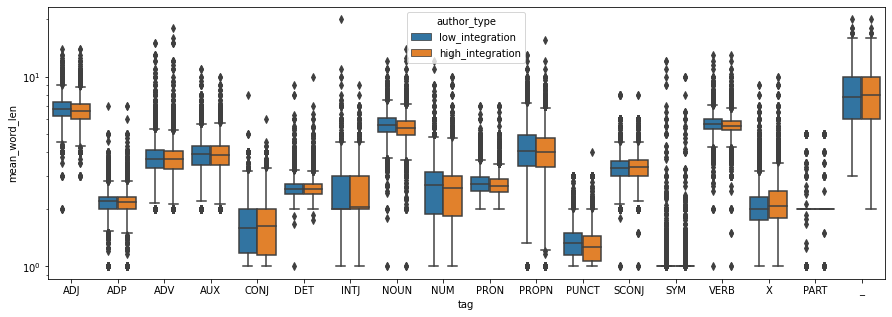

tag=ADJ, diff=-0.183 (test stat=9.049E+06, p=1.620E-20)
tag=INTJ, diff=0.065 (test stat=2.343E+06, p=2.264E-03)
tag=NOUN, diff=-0.226 (test stat=9.523E+06, p=3.109E-47)
tag=PRON, diff=-0.054 (test stat=9.816E+06, p=7.252E-16)
tag=PROPN, diff=-0.100 (test stat=8.004E+06, p=1.365E-04)
tag=PUNCT, diff=-0.056 (test stat=9.388E+06, p=4.447E-26)
tag=VERB, diff=-0.090 (test stat=1.025E+07, p=3.688E-18)
tag=X, diff=0.096 (test stat=8.492E+06, p=5.927E-14)


In [170]:
import seaborn as sns
plt.figure(figsize=(15, 5))
sns.boxplot(x='tag', y='mean_word_len', hue='author_type', data=clean_integration_author_POS_tag_word_len)
plt.yscale('log')
plt.show()
# which differences are significant?
from scipy.stats import mannwhitneyu
p_val_upper = 0.05 / clean_integration_author_POS_tag_word_len.loc[:, 'tag'].nunique()
for tag_i, data_i in clean_integration_author_POS_tag_word_len.groupby('tag'):
    low_integration_data_i = data_i[data_i.loc[:, 'author_type']=='low_integration'].loc[:, 'mean_word_len']
    high_integration_data_i = data_i[data_i.loc[:, 'author_type']=='high_integration'].loc[:, 'mean_word_len']
    mean_diff_i = high_integration_data_i.mean() - low_integration_data_i.mean()
    test_stat, p_val = mannwhitneyu(high_integration_data_i, low_integration_data_i)
    if(p_val < p_val_upper):
        print('tag=%s, diff=%.3f (test stat=%.3E, p=%.3E)'%(tag_i, mean_diff_i, test_stat, p_val))

Simpler question: which author group has more expressive lengthening?

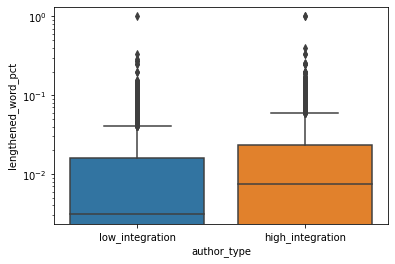

distributions have test stat 1.030E+07 (p=5.360E-26)


In [185]:
# lengthened_words = set(vocab) - set(clean_vocab_2)
# integration_author_lengthened_word_pct = integration_author_POS_words.groupby(['screen_name', 'author_type']).apply(lambda x: x[x.loc[:, 'word'].isin(lengthened_words)].shape[0] / x.loc[:, 'word'].nunique()).reset_index().rename(columns={0:'lengthened_word_pct'})
# show distribution
sns.boxplot(x='author_type', y='lengthened_word_pct', data=integration_author_lengthened_word_pct)
plt.yscale('log')
plt.show()
# significance test
from scipy.stats import mannwhitneyu
high_integration_lengthened_word_pct = integration_author_lengthened_word_pct[integration_author_lengthened_word_pct.loc[:, 'author_type']=='high_integration'].loc[:, 'lengthened_word_pct']
low_integration_lengthened_word_pct = integration_author_lengthened_word_pct[integration_author_lengthened_word_pct.loc[:, 'author_type']=='low_integration'].loc[:, 'lengthened_word_pct']
test_stat, p_val = mannwhitneyu(high_integration_lengthened_word_pct, low_integration_lengthened_word_pct)
print('distributions have test stat %.3E (p=%.3E)'%(test_stat, p_val))

OK! So high-integration native verb authors do consistently use lengthened words at a higher rate. 

All this leads me to suspect that high-integration native verb authors do, in fact, use less formal language on social media. This is inconsistent with what we know from the newspaper comparison!

### Original content: no URLs, hashtags, @-mentions

Does this persist even when we look at posts without user-mentions, URLs and hashtags?

In [89]:
import re
diff_audience_matcher = re.compile('@USER|<URL>|#HASH')
integration_author_post_data = integration_author_post_data.assign(**{
    'diff_audience' : integration_author_post_data.loc[:, 'clean_text'].apply(lambda x: diff_audience_matcher.search(x) is not None)
})
same_audience_integration_author_post_data = integration_author_post_data[~integration_author_post_data.loc[:, 'diff_audience']]

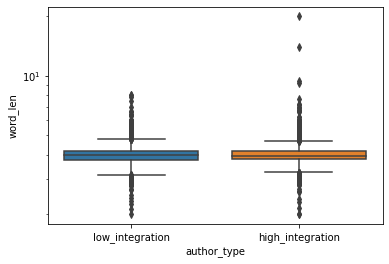

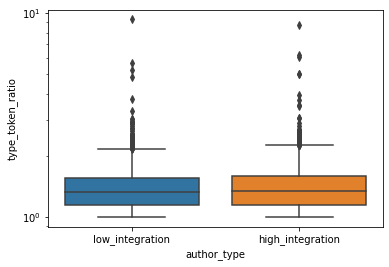

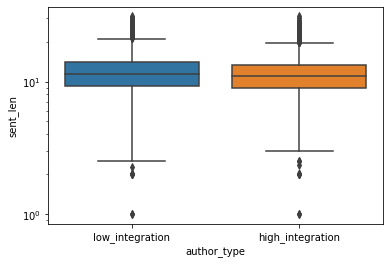

style var word_len has diff 0.002 with test stat 6206056.500 (p=2.475E-01)
style var type_token_ratio has diff 0.026 with test stat 6039379.000 (p=4.374E-03)
style var sent_len has diff -0.574 with test stat 5785681.000 (p=1.268E-08)


In [90]:
word_tokenizer = BasicTokenizer(lang='spanish')
sent_tokenizer = PunktSentenceTokenizer()
text_var = 'clean_text'
filter_words = set(['@USER', '#HASH', '<NUM>', '<URL>'])
filter_word_matcher = re.compile('|'.join(filter_words))
same_audience_integration_author_post_data = same_audience_integration_author_post_data.assign(**{
    'text_tokens' : same_audience_integration_author_post_data.loc[:, 'clean_text'].apply(lambda x: word_tokenize_clean(x, word_tokenizer, filter_word_matcher))
})
same_audience_integration_author_post_data = same_audience_integration_author_post_data.assign(**{
    'text_sents' : same_audience_integration_author_post_data.loc[:, 'clean_text'].apply(lambda x: sent_tokenize_clean(x, word_tokenizer, sent_tokenizer, filter_word_matcher))
})
# get tokens per author
from functools import reduce
integration_author_tokens = same_audience_integration_author_post_data.groupby(author_var).apply(lambda x: list(reduce(lambda y,z: y+z, x.loc[:, 'text_tokens'].values.tolist())))
# get sentences per author: list of token lists
integration_author_sents = same_audience_integration_author_post_data.groupby(author_var).apply(lambda x: list(reduce(lambda y,z: y+z, x.loc[:, 'text_sents'].values.tolist())))
# compute style per author
author_var = 'screen_name'
# remove any authors without tokens => filtering for @USER etc.
integration_author_tokens = integration_author_tokens[integration_author_tokens.apply(len) > 0]
integration_author_sents = integration_author_sents[integration_author_sents.apply(lambda x: len(list(filter(lambda y: len(y) > 0, x)))) > 0]
integration_author_word_length = integration_author_tokens.apply(lambda x: compute_word_length(x))
integration_author_type_token_ratio = integration_author_tokens.apply(lambda x: compute_type_token_ratio(x))
integration_author_sent_length = integration_author_sents.apply(lambda x: compute_sentence_length(x))
author_style_data = pd.concat([integration_author_word_length, integration_author_type_token_ratio, integration_author_sent_length], axis=1).reset_index().rename(columns={'index':'screen_name', 0:'word_len', 1:'type_token_ratio', 2:'sent_len'})
author_style_data = pd.merge(author_style_data, author_integration_type_data, on='screen_name')
# plot distributions
import seaborn as sns
style_vars = ['word_len', 'type_token_ratio', 'sent_len']
for style_var in style_vars:
    sns.boxplot(x='author_type', y=style_var, data=author_style_data)
    plt.yscale('log')
    plt.show()
# compare distributions
from scipy.stats import mannwhitneyu
for style_var in style_vars:
    data_1 = author_style_data[author_style_data.loc[:, 'author_type']=='high_integration'].loc[:, style_var]
    data_2 = author_style_data[author_style_data.loc[:, 'author_type']=='low_integration'].loc[:, style_var]
    mean_diff = data_1.mean() - data_2.mean()
    test_stat, p_val = mannwhitneyu(data_1, data_2)
    print('style var %s has diff %.3f with test stat %.3f (p=%.3E)'%(style_var, mean_diff, test_stat, p_val))

OK! High-integration authors have:

- higher type-token ratio
- lower sentence length

Show sample sentences.

In [92]:
import numpy as np
np.random.seed(123)
sample_size = 100
author_var = 'screen_name'
author_type_var = 'author_type'
high_integration_sample_authors = np.random.choice(same_audience_integration_author_post_data[same_audience_integration_author_post_data.loc[:, author_type_var]=='high_integration'].loc[:, author_var].values, sample_size, replace=False)
low_integration_sample_authors = np.random.choice(same_audience_integration_author_post_data[same_audience_integration_author_post_data.loc[:, author_type_var]=='low_integration'].loc[:, author_var].values, sample_size, replace=False)
high_integration_sample_sents = same_audience_integration_author_post_data[same_audience_integration_author_post_data.loc[:, author_var].isin(high_integration_sample_authors)].loc[:, 'text_sents']
low_integration_sample_sents = same_audience_integration_author_post_data[same_audience_integration_author_post_data.loc[:, author_var].isin(low_integration_sample_authors)].loc[:, 'text_sents']
print('high-integration author sentences')
print(high_integration_sample_sents.values[:20])
print('low-integration author sentences')
print(low_integration_sample_sents.values[:20])

high-integration author sentences
[list([['en', 'tw', 'si', 'hay', 'mujeres', 'sexys', 'loco😱']])
 list([['siempre', 'lo', 'he', 'sostenido', ';', '¿de', 'qué', 'vale', 'vivir', 'en', 'el', 'país', 'de', 'las', 'mujeres', 'más', 'hermosa', 'del', 'mundo', 'si', 'ninguna', 'me', 'para', 'bolas', '?'], ['😒🙄']])
 list([['cada', 'día', 'que', 'despierto', ',', 'leo', 'son', 'puras', 'noticias', 'malas', 'y', 'negativas', 'para', 'nuestro', 'país', 'y', 'la', 'situación', '.'], ['qué', 'triste😌😌']])
 list([['hoy', 'estuvo', 'muy', 'rudo', 'el', 'día', ',', 'en', 'lh', 'nos', 'dieron', 'fuerte', 'los', 'guardias', 'y', 'el', 'conas', '.']])
 list([['mañana', 'cumple', 'años', 'mi', 'negra', 'y', 'qué', 'ladilla', 'que', 'viva', 'tan', 'lejos', ',', 'no', 'es', 'justo', '.']])
 list([['todos', 'necesitamos', 'rodearnos', 'de', 'gente', 'que', 'se', 'alegre', 'más', 'por', 'nuestro', 'cumpleaños', 'que', 'nosotros', 'mismos', '.']])
 list([['definitivamente', 'nunca', 'voy', 'a', 'salir', 'de'

Repeat POS tag comparison.

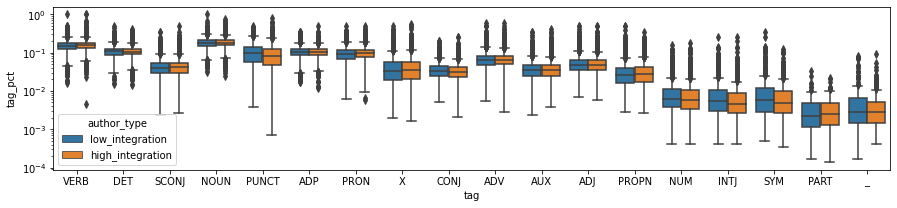

tag INTJ has diff -0.002, test stat=327974.500 (p=3.549E-05)
tag PRON has diff 0.003, test stat=5146071.500 (p=3.575E-04)
tag PUNCT has diff -0.014, test stat=4383429.500 (p=1.478E-24)
tag VERB has diff 0.008, test stat=5359667.500 (p=6.064E-16)


In [91]:
author_var = 'screen_name'
author_type_var = 'author_type'
integration_author_tag_distribution = same_audience_integration_author_post_data.groupby([author_var, author_type_var]).apply(lambda x: compute_tag_distribution(x.loc[:, 'tagged_sent'].values)).reset_index().rename(columns={'level_2':'tag', 0:'tag_pct'})
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,3))
sns.boxplot(x='tag', y='tag_pct', hue='author_type', data=integration_author_tag_distribution)
plt.yscale('log')
plt.show()
from scipy.stats import mannwhitneyu
p_val_upper = 0.05 / integration_author_tag_distribution.loc[:, 'tag'].nunique()
for tag_i, data_i in integration_author_tag_distribution.groupby('tag'):
    high_integration_author_tag_pct = data_i[data_i.loc[:, 'author_type']=='high_integration'].loc[:, 'tag_pct']
    low_integration_author_tag_pct = data_i[data_i.loc[:, 'author_type']=='low_integration'].loc[:, 'tag_pct']
    mean_diff = high_integration_author_tag_pct.mean() - low_integration_author_tag_pct.mean()
    test_stat, p_val = mannwhitneyu(high_integration_author_tag_pct, low_integration_author_tag_pct)
    if(p_val < p_val_upper):
        print('tag %s has diff %.3f, test stat=%.3f (p=%.3E)'%(tag_i, mean_diff, test_stat, p_val))

High integration authors use:
- fewer interjections
- more pronouns
- less punctuation
- more verbs

### Compare with loanword verb integration
The previous analysis focused only on high-integration and low-integration authors based on native verb use.

Let's repeat this analysis with loanword verb use.

,loanword,loanword_verb,loanword_type,screen_name,user_id,text,created_at,id,user_description,user_location,...,log_latin_american_media_pct,log_media_URL_pct,log_integrated_verb_pct,log_post_pct,log_URL_share_pct,log_RT_pct,log_balanced_latin_american_media_pct,es_bin,latin_american_media_pct_bin,balanced_latin_american_media_pct_bin
0,audit,auditamos,integrated_loanword,garrachavista,779318307585396736,@Sheiladarsy @anticuarta4 Y dime tu cuales 7.6...,2017-08-01T22:06:25+00:00,892506833197424640,100% a la izquierda,Venezuela,...,NaN,NaN,0.00995,-1.782600,-4.60517,-0.283532,NaN,es_high,NaN,NaN
1,ban,baneamos,integrated_loanword,emmanuelkiller5,4273648032,@adameamiro Eres tan hipocrita que antes nos h...,2017-07-04T23:08:51+00:00,882375684823203841,"Felicidad?Que es eso, lo que todos siempre me ...","Chihuahua, Chihuahua",...,NaN,NaN,NaN,-2.197817,-4.60517,-2.176408,NaN,es_high,NaN,NaN
2,ban,baneamos,integrated_loanword,danitolocirio13,482233447,@LVPibai Ibai te hace una normal de reclu? Así...,2017-08-06T00:58:05+00:00,893999585953185793,#21. Me gusta Love Live. Reborn. Baraggan y Es...,"Valladolid, España",...,NaN,NaN,0.00995,-3.153316,-4.60517,-0.824233,NaN,es_high,NaN,NaN
3,flip,flipas,integrated_loanword,danitolocirio13,482233447,Me echaba unas rankeds ahora que flipas,2018-01-07T02:58:26+00:00,949837604362612736,#22. Vago...,"Valladolid, España",...,NaN,NaN,0.00995,-3.153316,-4.60517,-0.824233,NaN,es_high,NaN,NaN
4,ban,banear,integrated_loanword,vcf973,883037197754093569,@MiiKeLMsT MIKEEL! CASI ME BANEAN POR COMPRAR ...,2017-08-20T14:29:57+00:00,899277329012334593,.,Tenerife,...,NaN,NaN,NaN,-3.696314,-4.60517,-4.605170,NaN,NaN,NaN,NaN


screen_name
zzzeta             1.0
guillegonella      1.0
guillefont123      1.0
guilleefiore       1.0
guilleeaparicio    1.0
dtype: float64

screen_name
grandesmedios      1.0
gritonasmx         1.0
hernanporrasm      1.0
hergonled          1.0
geraldineduplat    1.0
inforeportes       1.0
infolecturas       1.0
infoapuntes        1.0
indirajacome       1.0
isalmamudown       1.0
dtype: float64

screen_name
mundialdelpop10    0.0
quitoactivo        0.0
entel_ayuda        0.0
noechenchual       0.0
pdcsvgomez         0.0
claroteayuda       0.0
sendurtweet        0.0
drycacosta94       0.0
scawrrletwitch     0.0
cyrusfeeling       0.0
dtype: float64

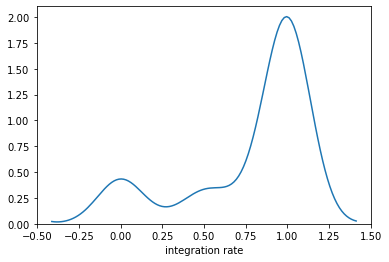

123 high integration authors
58 low integration authors
        screen_name       author_type
0     grandesmedios  high_integration
1        gritonasmx  high_integration
2     hernanporrasm  high_integration
3         hergonled  high_integration
4   geraldineduplat  high_integration
..              ...               ...
53     claroteayuda   low_integration
54      sendurtweet   low_integration
55     drycacosta94   low_integration
56   scawrrletwitch   low_integration
57     cyrusfeeling   low_integration

[181 rows x 2 columns]


In [94]:
# load loanword data
import pandas as pd
loanword_verb_post_author_data = pd.read_csv('../../data/mined_tweets/loanword_verbs_post_social_data.tsv', sep='\t')
display(loanword_verb_post_author_data.head())
# load prior data
from data_helpers import load_data_from_dirs
data_dir = '../../data/mined_tweets/loanword_author_tweets_all_archives/'
use_cols = ['screen_name', 'lang', 'lang_score', 'text', 'urls']
author_post_data = load_data_from_dirs([data_dir], use_cols=use_cols)
author_post_data.fillna('', inplace=True)
# clean text for matching
author_post_data = author_post_data.assign(**{
    'clean_text' : author_post_data.loc[:, 'text'].apply(lambda x: x.lower())
})
# identify high-integration authors
# per-author integration rate
def compute_integration_rate(data, word_var='native_word_type'):
    integrated_rate = data.groupby(word_var).apply(lambda x: 1-(x.loc[:, 'has_light_verb'].sum() / x.shape[0])).mean()
    return integrated_rate
author_var = 'screen_name'
word_var = 'loanword'
per_author_integration = loanword_verb_post_author_data.groupby(author_var).apply(lambda x: compute_integration_rate(x, word_var=word_var))
per_author_integration.sort_values(inplace=True, ascending=False)
display(per_author_integration.head())
# filter by count
author_counts = loanword_verb_post_author_data.loc[:, author_var].value_counts()
min_count = 5
freq_authors = author_counts[author_counts >= min_count].index.tolist()
freq_author_integration = per_author_integration[per_author_integration.index.isin(freq_authors)]
display(freq_author_integration.head(10))
display(freq_author_integration.tail(10))
# plot distribution of integration rates
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.kdeplot(freq_author_integration)
plt.xlabel('integration rate')
plt.show()
high_integration_cutoff = 1.
high_integration_authors = freq_author_integration[freq_author_integration >= high_integration_cutoff].index.tolist()
low_integration_authors = freq_author_integration[freq_author_integration < high_integration_cutoff].index.tolist()
print('%d high integration authors'%(len(high_integration_authors)))
print('%d low integration authors'%(len(low_integration_authors)))
# store as author-type data for later
author_integration_type_data = pd.concat([pd.DataFrame(high_integration_authors, columns=['screen_name']).assign(**{'author_type':'high_integration'}), 
                                          pd.DataFrame(low_integration_authors, columns=['screen_name']).assign(**{'author_type':'low_integration'})])
print(author_integration_type_data)

Overall we see a much smaller proportion of authors covered here.

In [ ]:
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import conjugate_verb, conjugate_light_verb, remove_ambiguous_verb_forms
import re
# get loanword query data
loanword_integrated_verb_query_data = pd.read_csv('../../data/loanword_resources/wiktionary_twitter_reddit_loanword_verbs_integrated_verbs_query_phrases.tsv', sep='\t').rename(columns={'verb' : 'integrated_verb_query'})
loanword_light_verb_query_data = pd.read_csv('../../data/loanword_resources/wiktionary_twitter_reddit_loanword_verbs_light_verbs_query_phrases.tsv', sep='\t').rename(columns={'verb' : 'light_verb_query'})
loanword_query_data = pd.merge(loanword_integrated_verb_query_data, loanword_light_verb_query_data, on='loanword')
# get native verb query data
native_verb_query_data = pd.read_csv('../../data/loanword_resources/native_verb_light_verb_pairs.csv', sep=',')
# generate queries
native_verb_query_data = native_verb_query_data.assign(**{
    'integrated_verb_query' : native_verb_query_data.loc[:, 'integrated_verb'].apply(lambda x: re.compile('|'.join(remove_ambiguous_verb_forms(conjugate_verb(x))))),
    'light_verb_query' : native_verb_query_data.loc[:, 'light_verb'].apply(lambda x: re.compile('|'.join(list(map(lambda y: f'({y})', conjugate_light_verb(x)))))),
})
# get matchers
loanword_matchers = (
    loanword_query_data.loc[:, 'integrated_verb_query'].apply(lambda x: re.compile(x)).values.tolist() + 
    loanword_query_data.loc[:, 'light_verb_query'].apply(lambda x: re.compile(x)).values.tolist()
                    )
native_verb_matchers = (
    native_verb_query_data.loc[:, 'integrated_verb_query'].apply(lambda x: re.compile(x)).values.tolist() + 
    native_verb_query_data.loc[:, 'light_verb_query'].apply(lambda x: re.compile(x)).values.tolist()
)
def match_any(text, matchers):
    for matcher in matchers:
        if(matcher.search(text) is not None):
            return True
    return False
from pandarallel import pandarallel
## WARNING this may blow up memory because it copies (??) all the data between processes
JOBS = 10
pandarallel.initialize(nb_workers=JOBS)
author_post_data = author_post_data.assign(**{
    'contains_loanword' : author_post_data.loc[:, 'clean_text'].parallel_apply(lambda x: match_any(x, loanword_matchers))
})
author_post_data = author_post_data.assign(**{
    'contains_native_verb' : author_post_data.loc[:, 'clean_text'].parallel_apply(lambda x: match_any(x, native_verb_matchers))
})
# restrict to original data
# filter out RT posts
import re
RT_matcher = re.compile('^RT @\w+')
txt_var = 'text'
author_post_data = author_post_data.assign(**{
    'is_shared' : author_post_data.loc[:, txt_var].apply(lambda x: RT_matcher.search(x) is not None)
})
# filter out media posts
matcher = re.compile('(?<=youtube\.com/watch\?v=)[a-zA-Z0-9_\-]+|(?<=youtu\.be/)[a-zA-Z0-9_\-]+|(?<=spotify\.com/track/)[a-zA-Z0-9]+')
author_post_data = author_post_data.assign(**{
    'has_media' : author_post_data.loc[:, txt_var].apply(lambda x: matcher.search(x) is not None)
})
original_author_post_data = author_post_data[~(author_post_data.loc[:, 'is_shared'] | author_post_data.loc[:, 'has_media'])]
# restrict to actual Spanish data
lang = 'es'
# es_original_author_post_data = original_author_post_data[original_author_post_data.loc[:, 'lang_score']!='']
es_original_author_post_data = original_author_post_data[(original_author_post_data.loc[:, 'lang']==lang)]
# clean text
from data_helpers import clean_tweet_txt
es_original_author_post_data = es_original_author_post_data.assign(**{
    'clean_text' : es_original_author_post_data.loc[:, txt_var].apply(clean_tweet_txt)
})
# combine with author data
author_var = 'screen_name'
integration_author_post_data = pd.merge(es_original_author_post_data, author_integration_type_data, on=author_var)
print(integration_author_post_data.shape[0])
# save for later??
# regex operations are expensive
integration_author_post_data.to_csv('../../data/mined_tweets/loanword_verb_high_low_integration_author_data.tsv', sep='\t', index=False)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [96]:
integration_author_post_data.head()

,text,screen_name,lang,lang_score,urls,file_dir,clean_text,contains_loanword,contains_native_verb,is_shared,has_media,author_type
0,Para ser sincera le tengo miedo a este nuevo s...,cyrusfeeling,es,98,,loanword_author_tweets_all_archives,para ser sincera le tengo miedo a este nuevo s...,False,False,False,False,low_integration
1,Además nos encontramos a Villalobos en el aero...,cyrusfeeling,es,99,,loanword_author_tweets_all_archives,además nos encontramos a villalobos en el aero...,False,True,False,False,low_integration
2,@loveonlyselena ES MUY CIERTO JAJAJAJAJAJAJAJA...,cyrusfeeling,es,99,,loanword_author_tweets_all_archives,@USER es muy cierto jajajajajajajajajajajajaja...,True,False,False,False,low_integration
3,EN EL INSTA DE @ BRETUTV ESTÁ LA COBERTURA DE ...,cyrusfeeling,es,99,,loanword_author_tweets_all_archives,en el insta de @USER está la cobertura de la c...,False,False,False,False,low_integration
4,La mejor manera de persuasión de maluma para t...,cyrusfeeling,es,99,,loanword_author_tweets_all_archives,la mejor manera de persuasión de maluma para t...,False,False,False,False,low_integration


In [102]:
# compute style variables
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import BasicTokenizer, word_tokenize_clean, sent_tokenize_clean, compute_word_length, compute_sentence_length, compute_type_token_ratio, compute_tag_distribution
from nltk.tokenize import PunktSentenceTokenizer
import re
word_tokenizer = BasicTokenizer(lang='spanish')
sent_tokenizer = PunktSentenceTokenizer()
text_var = 'clean_text'
filter_words = set(['@USER', '#HASH', '<NUM>', '<URL>'])
filter_word_matcher = re.compile('|'.join(filter_words))
integration_author_post_data = integration_author_post_data.assign(**{
    'text_tokens' : integration_author_post_data.loc[:, 'clean_text'].apply(lambda x: word_tokenize_clean(x, word_tokenizer, filter_word_matcher))
})
integration_author_post_data = integration_author_post_data.assign(**{
    'text_sents' : integration_author_post_data.loc[:, 'clean_text'].apply(lambda x: sent_tokenize_clean(x, word_tokenizer, sent_tokenizer, filter_word_matcher))
})
# get tokens per author
from functools import reduce
integration_author_tokens = integration_author_post_data.groupby(author_var).apply(lambda x: list(reduce(lambda y,z: y+z, x.loc[:, 'text_tokens'].values.tolist())))
# get sentences per author: list of token lists
integration_author_sents = integration_author_post_data.groupby(author_var).apply(lambda x: list(reduce(lambda y,z: y+z, x.loc[:, 'text_sents'].values.tolist())))
# compute style per author
author_var = 'screen_name'
# remove any authors without tokens => filtering for @USER etc.
integration_author_tokens = integration_author_tokens[integration_author_tokens.apply(len) > 0]
integration_author_sents = integration_author_sents[integration_author_sents.apply(lambda x: len(list(filter(lambda y: len(y) > 0, x)))) > 0]
integration_author_word_length = integration_author_tokens.apply(lambda x: compute_word_length(x))
integration_author_type_token_ratio = integration_author_tokens.apply(lambda x: compute_type_token_ratio(x))
integration_author_sent_length = integration_author_sents.apply(lambda x: compute_sentence_length(x))
# combine
author_style_data = pd.concat([integration_author_word_length, integration_author_type_token_ratio, integration_author_sent_length], axis=1).reset_index().rename(columns={'index':'screen_name', 0:'word_len', 1:'type_token_ratio', 2:'sent_len'})
author_style_data = pd.merge(author_style_data, author_integration_type_data, on='screen_name')

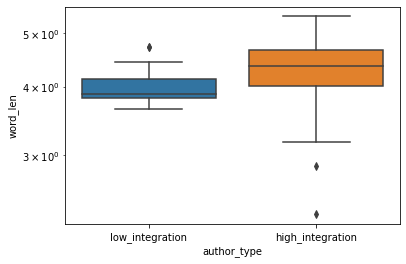

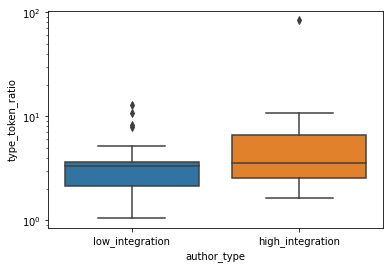

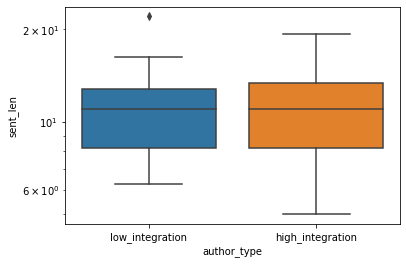

style var word_len has diff 0.243 with test stat 224.000 (p=5.553E-03)
style var type_token_ratio has diff 2.548 with test stat 315.000 (p=1.506E-01)
style var sent_len has diff -0.289 with test stat 376.000 (p=4.901E-01)


In [103]:
# plot distributions
import seaborn as sns
style_vars = ['word_len', 'type_token_ratio', 'sent_len']
for style_var in style_vars:
    sns.boxplot(x='author_type', y=style_var, data=author_style_data)
    plt.yscale('log')
    plt.show()
# compare distributions
from scipy.stats import mannwhitneyu
for style_var in style_vars:
    data_1 = author_style_data[author_style_data.loc[:, 'author_type']=='high_integration'].loc[:, style_var]
    data_2 = author_style_data[author_style_data.loc[:, 'author_type']=='low_integration'].loc[:, style_var]
    mean_diff = data_1.mean() - data_2.mean()
    test_stat, p_val = mannwhitneyu(data_1, data_2)
    print('style var %s has diff %.3f with test stat %.3f (p=%.3E)'%(style_var, mean_diff, test_stat, p_val))

The only significant difference we see is that high-integration authors have higher word length.

Let's run the tag test for completeness.

In [104]:
# get POS tags
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import tag_sents
lang = 'spanish'
integration_author_sents = integration_author_post_data.loc[:, 'clean_text'].values
# WARNING parallel tagging blows up memory
tag_type = 'parallel'
# takes ~5 mins for 50K sentences
# takes several hours for 500K sentences?? ugh!
integration_author_tagged_sents = tag_sents(integration_author_sents, lang=lang, port=9003, tag_type=tag_type)
# compute distribution
integration_author_post_data = integration_author_post_data.assign(**{
    'tagged_sent' : integration_author_tagged_sents
})
author_var = 'screen_name'
author_type_var = 'author_type'
integration_author_tag_distribution = integration_author_post_data.groupby([author_var, author_type_var]).apply(lambda x: compute_tag_distribution(x.loc[:, 'tagged_sent'].values)).reset_index().rename(columns={'level_2':'tag', 0:'tag_pct'})

INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


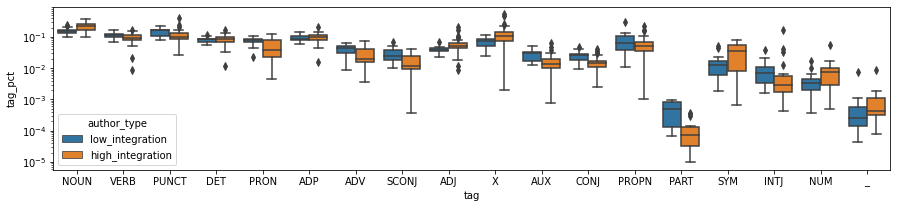

tag ADJ has diff 0.021, test stat=141.000 (p=4.569E-05)
tag AUX has diff -0.011, test stat=132.000 (p=2.104E-04)
tag CONJ has diff -0.008, test stat=140.000 (p=9.638E-04)
tag NOUN has diff 0.058, test stat=136.000 (p=3.233E-05)
tag PRON has diff -0.026, test stat=170.000 (p=1.922E-03)
tag SCONJ has diff -0.013, test stat=143.000 (p=9.703E-04)
tag X has diff 0.063, test stat=192.000 (p=1.530E-03)


In [106]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,3))
sns.boxplot(x='tag', y='tag_pct', hue='author_type', data=integration_author_tag_distribution)
plt.yscale('log')
plt.show()
from scipy.stats import mannwhitneyu
p_val_upper = 0.05 / integration_author_tag_distribution.loc[:, 'tag'].nunique()
for tag_i, data_i in integration_author_tag_distribution.groupby('tag'):
    high_integration_author_tag_pct = data_i[data_i.loc[:, 'author_type']=='high_integration'].loc[:, 'tag_pct']
    low_integration_author_tag_pct = data_i[data_i.loc[:, 'author_type']=='low_integration'].loc[:, 'tag_pct']
    mean_diff = high_integration_author_tag_pct.mean() - low_integration_author_tag_pct.mean()
    test_stat, p_val = mannwhitneyu(high_integration_author_tag_pct, low_integration_author_tag_pct)
    if(p_val < p_val_upper):
        print('tag %s has diff %.3f, test stat=%.3f (p=%.3E)'%(tag_i, mean_diff, test_stat, p_val))

High-integration authors use more:
- `ADJ`
- `NOUN`
- `X`

High=integration authors use less:
- `AUX`
- `CONJ`
- `PRON`
- `SCONJ`